# Imports

In [22]:
import os
import logging
import pandas as pd
import datetime
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.pyplot import Polygon
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter, MinuteLocator
import matplotlib.ticker as ticker

try:
    from PT3S import dxAndMxHelperFcts
except:
    import dxAndMxHelperFcts

try:
    from PT3S import Rm
except:
    import Rm

In [2]:
pt3s_path = os.path.dirname(os.path.abspath(dxAndMxHelperFcts.__file__))

# Logging

In [3]:
logger = logging.getLogger()  

logFileName= r"Example2.log" 

loglevel = logging.DEBUG
logging.basicConfig(filename=logFileName
                        ,filemode='w'
                        ,level=loglevel
                        ,format="%(asctime)s ; %(name)-60s ; %(levelname)-7s ; %(message)s")    

fileHandler = logging.FileHandler(logFileName)     

logger.addHandler(fileHandler)

consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logging.Formatter("%(levelname)-7s ; %(message)s"))
consoleHandler.setLevel(logging.INFO)
logger.addHandler(consoleHandler)

# Model and Time Curves

In [4]:
dbFilename="Wärmenetz-Planungsbeispiel"

In [5]:
csvFilename="time_curves"

# Read Model and Time Curves

In [6]:
file_path=pt3s_path+'/Examples/'+csvFilename+'.csv'

In [7]:
def read_multiple_time_curves(file_path):
    with open(file_path, 'r', encoding='ISO-8859-1') as f:
        lines = f.readlines()

    dataframes = []
    current_lines = []
    curve_name = ''
    for line in lines:
        if line.strip() == ';' or line.strip() == '':
            if current_lines:
                df = pd.DataFrame([sub.split(";") for sub in current_lines[2:]])  # Skip the first two lines
                df = df.iloc[:, :2]  # Only take the first two columns
                df.columns = ['Datetime', curve_name]  # Rename the columns
                dataframes.append(df)
                current_lines = []
        else:
            if 'Zeitkurven' in line:
                curve_name = line.split(' ')[1]  # Extract the curve name
            current_lines.append(line.strip())

    if current_lines:
        df = pd.DataFrame([sub.split(";") for sub in current_lines[2:]])  # Skip the first two lines
        df = df.iloc[:, :2]  # Only take the first two columns
        df.columns = ['Datetime', curve_name]  # Rename the columns
        dataframes.append(df)

    return dataframes

In [8]:
time_curves_dataframes = read_multiple_time_curves(file_path)

In [140]:
time_curves_dataframes[1].head()

,Datetime,Umwälzmenge;\n
0,2023-02-13 00:00:00,287.090057
1,2023-02-13 01:00:00,290.241272
2,2023-02-13 02:00:00,294.834534
3,2023-02-13 03:00:00,309.798828
4,2023-02-13 04:00:00,347.568024


# Plotting

## Prepare Data

In [126]:
datetime_format = '%Y-%m-%d %H:%M:%S,%f'

for df in time_curves_dataframes:
    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], format='%Y-%m-%d %H:%M:%S,%f')
    df.iloc[:, 1] = df.iloc[:, 1].str.replace(',', '.')
    df.iloc[:, 1] = pd.to_numeric(df.iloc[:, 1], errors='coerce')

In [ ]:
#Mapping for ax Functions

## Define Functions

In [141]:
def fyP(ax,offset=0):
    ax.spines["left"].set_position(("outward", offset))
    ax.set_ylabel('Druck in bar')
    ax.set_ylim(0,24)
    ax.set_yticks(sorted(np.append(np.linspace(0,24,25),[])))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')
    
def fyT(ax,offset=60):
    Rm.pltLDSHelperY(ax)
    ax.spines["left"].set_position(("outward",offset))
    ax.set_ylabel('Temperatur in °C')
    ax.set_ylim(0,144)
    ax.set_yticks(sorted(np.append(np.linspace(0,144,25),[])))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')
    
def fyQ(ax,offset=120):
    Rm.pltLDSHelperY(ax)
    ax.spines["left"].set_position(("outward",offset))
    ax.set_ylabel('Durchfluss in m3/h')
    ax.set_ylim(0,3840)
    ax.set_yticks(sorted(np.append(np.linspace(0,3840,25),[])))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')
    
def fyW(ax,offset=180):
    Rm.pltLDSHelperY(ax)
    ax.spines["left"].set_position(("outward",offset))
    ax.set_ylabel('Wärmeleistung in MW')
    ax.set_ylim(0,25)
    ax.set_yticks(sorted(np.append(np.linspace(0,25,6),[])))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')
    
def fyNY(ax,offset=240):
    Rm.pltLDSHelperY(ax)
    ax.spines["left"].set_position(("outward",offset))
    ax.set_ylabel('Drehzahl in Y')
    ax.set_ylim(0, 100)
    ax.set_yticks(sorted(np.append(np.linspace(0,100,25),[])))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')

def fyNrpm(ax,offset=240):
    Rm.pltLDSHelperY(ax)
    ax.spines["left"].set_position(("outward",offset))
    ax.set_ylabel('Drehzahl in rpm')
    ax.set_ylim(0, 2400)
    ax.set_yticks(sorted(np.append(np.linspace(0,2400,25),[])))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')

def fyUmwMe(ax,offset=300):
    Rm.pltLDSHelperY(ax)
    ax.spines["left"].set_position(("outward",offset))
    ax.set_ylabel('Umwälzmenge in ###')
    ax.set_ylim(250, 600)
    ax.set_yticks(sorted(np.append(np.linspace(250, 600,25),[])))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')

In [171]:
def plotAll(dfs
            ,should_plot 
            ,Startzeit=time_curves_dataframes[0].iloc[0, 0]
            ,Endzeit=time_curves_dataframes[0].iloc[24, 0]):
    
    # Create a new figure and axis
    fig, ax0 = plt.subplots()

    # Set y-axis ticks and labels
    ax0.set_yticks(np.linspace(0, 24, 25))
    ax0.yaxis.set_ticklabels([])
    ax0.grid()

    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for i, df in enumerate(dfs):
        if should_plot[i]:
            ax_i = ax0.twinx()  
            fyW(ax_i, i*60)#Mapping needed
            ax_i.plot(dfs[i].iloc[:, 0], dfs[i].iloc[:, 1], color=colors[i % len(colors)], lw=plt.rcParams['lines.linewidth']*2, ls='solid')
    
    #if Wärmeleistung:
    #    ax1 = ax0.twinx()
    #    fyW(ax1, 0)
    #    ax1.plot(dfs[0].iloc[:, 0], dfs[0].iloc[:, 1], color='blue', lw=plt.rcParams['lines.linewidth']*2, ls='solid')

    #if Temperatur:#Not really a Temp
    #    ax2 = ax0.twinx()
    #    fyUmwMe(ax2, 60)
    #    ax2.plot(dfs[1].iloc[:, 0], dfs[1].iloc[:, 1], color='red', lw=plt.rcParams['lines.linewidth']*2, ls='solid')
    
    ax0.set_xlim(Startzeit, Endzeit)

    Rm.pltHelperX(ax0, dateFormat='%Hh:%Mm', byminute=[0, 60], yPos=0)

    # Set the title of the plot
    Name = f"Prozessdaten West {df.iloc[:, 0].min().strftime('%Y %m %d')}"
    plotTitle = f"West von {Startzeit.strftime('%Y %m %d %Hh %Mm %Ss')} bis {Endzeit.strftime('%Y %m %d %Hh %Mm %Ss')}"
    ax0.set_title(plotTitle)

    # Adjust the layout
    plt.subplots_adjust(left=0.3, bottom=0.15)

    # Show the plot
    plt.show()

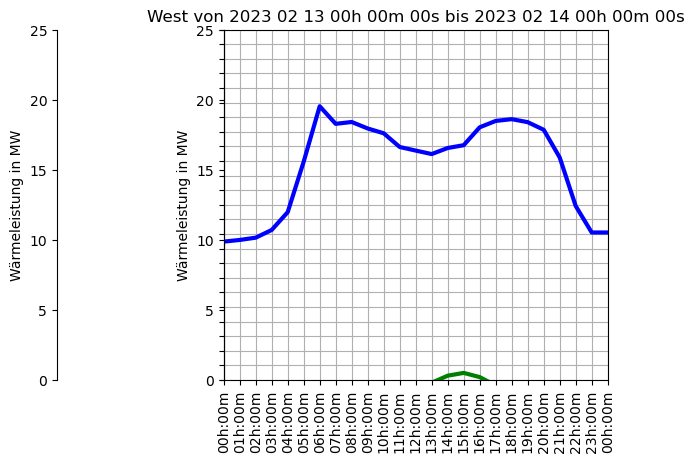

In [172]:
plotAll(time_curves_dataframes, [True, False, True])

TimePicker(value=datetime.time(8, 0), description='Zeitpunkt:', step=60.0)

TimePicker(value=datetime.time(0, 1), description='Startzeit:', min=datetime.time(0, 1), step=60.0)

TimePicker(value=datetime.time(0, 0), description='Endzeit:', step=60.0)

Checkbox(value=True, description='MW;\n')

Checkbox(value=True, description='Umwälzmenge;\n')

Checkbox(value=True, description='AT;\n')

TypeError: 'datetime.datetime' object is not subscriptable

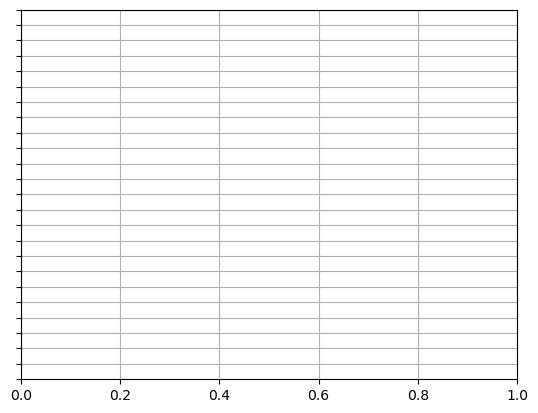

In [178]:
import ipywidgets as widgets
from IPython.display import display
import datetime

# Create TimePicker widgets for selecting specific times
Zeitpunkt = widgets.TimePicker(value=datetime.time(8, 0), description='Zeitpunkt:')
Startzeit = widgets.TimePicker(value=datetime.time(0, 1), min=datetime.time(0, 1), description='Startzeit:')
Endzeit = widgets.TimePicker(value=datetime.time(0, 0), description='Endzeit:')

# Create a dictionary to hold the checkboxes for measurement options
checkboxes = {}

# Dynamically create checkboxes based on the second column names of the dataframes
for df in time_curves_dataframes:
    column_name = df.columns[1]
    checkboxes[column_name] = widgets.Checkbox(value=True, description=column_name)

# Function to update the plot based on the widgets' values
def update_plot(_=None):
    # Convert widget times to datetime.datetime objects
    start_datetime = datetime.datetime.combine(datetime.date.today(), Startzeit.value)
    end_datetime = datetime.datetime.combine(datetime.date.today(), Endzeit.value)
    
    # Prepare a list of selected measurements based on the checkboxes
    selected_measurements = [key for key, checkbox in checkboxes.items() if checkbox.value]
    
    # Call the plotAll function with the selected parameters
    plotAll(time_curves_dataframes, start_datetime, end_datetime, selected_measurements)

# Observe changes in the widgets and update the plot accordingly
Startzeit.observe(update_plot, 'value')
Endzeit.observe(update_plot, 'value')
for checkbox in checkboxes.values():
    checkbox.observe(update_plot, 'value')

# Display the widgets
display(Zeitpunkt, Startzeit, Endzeit, *checkboxes.values())

# Initial plot
update_plot()


In [177]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import interactive
import datetime
import matplotlib.pyplot as plt
import numpy as np

# Assume 'time_curves_dataframes' is a list of dataframes available in your context
# Assume 'plotAll' function is defined as per the previous discussion

# Create TimePicker widgets for selecting specific times
Startzeit_widget = widgets.TimePicker(value=datetime.time(0, 1), description='Startzeit:')
Endzeit_widget = widgets.TimePicker(value=datetime.time(23, 59), description='Endzeit:')

# Create a dictionary to hold the checkboxes for measurement options
checkboxes = {}
for df in time_curves_dataframes:
    column_name = df.columns[1]
    checkboxes[column_name] = widgets.Checkbox(value=True, description=column_name)

# Function to convert TimePicker values to datetime objects
def get_datetime(time_picker):
    return datetime.datetime.combine(datetime.date.today(), time_picker.value)

# Function to collect the states of the checkboxes
def get_should_plot():
    return [checkbox.value for checkbox in checkboxes.values()]

# Use the interactive function to link widgets to the plotAll function
interactive_plot = interactive(plotAll,
                               dfs=widgets.fixed(time_curves_dataframes),
                               should_plot=widgets.fixed(get_should_plot()),
                               Startzeit=widgets.fixed(get_datetime(Startzeit_widget)),
                               Endzeit=widgets.fixed(get_datetime(Endzeit_widget)))

# Display the widgets and the interactive plot
display(Startzeit_widget, Endzeit_widget, *checkboxes.values())
display(interactive_plot)


ImportError: cannot import name 'interactive' from 'IPython.display' (C:\Users\jablonski\AppData\Local\anaconda3\Lib\site-packages\IPython\display.py)